# CSCA 5642 Week 3 CNN Cancer Detection Mini-Project

## Problem Description
The aim of this project is to build a deep learning model to predict tumors/cancer in tissue images. Given unlabeled images of human tissue, we want to train a model that classifies them as either positive or negative for any number of tumor pixels. This project is given as a submission to the [Histopathologic Cancer Detection Kaggle Competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data).

This notebook contains the standard pipeline for data processing, exploratory data analysis, model development, and inference. The model score is given by the submission to the Kaggle competition.

In [67]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm 

from image_dataset import CustomImageDataset

In [66]:
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name()}")
else:
    print(f"No available GPU.")

Available GPU: NVIDIA GeForce RTX 3070 Ti


## Exploratory Data Analysis

The dataset is made up of 3 main files:
* `train`: folder containing 96x96x3 pixel images with resolved labels. The third dimension e.g. 3, indicates 3 color channels. 
* `test`: folder containing images processed in the same format as `train` without labels, used for inference.
* `train_labels.csv`: data file containing the labels mapped to image `id`.

### Load data labels

In [62]:
train_labels = pd.read_csv("data/histopathologic-cancer-detection/train_labels.csv")
train_labels.head()
print(f"Number of training examples: {train_labels.shape[0]}")

Number of training examples: 220025


The `train_labels.csv` file gives the ground-truth for each image, mapped by `id`.
* `1`: cancer tissue is present in the image (any number of pixels)
* `0`: no cancer tissue is present in the image

### Load image sample

In [63]:
train_fp = "data/histopathologic-cancer-detection/train/"
test_fp = "data/histopathologic-cancer-detection/test/"

In [64]:
def display_images(fp, m, n, mapping=None):
    image_files = [i for i in os.listdir(fp)]

    images = []
    labels = []
    for image in image_files[:(m*n)]:
        image_fp = os.path.join(fp, image)
        images.append(Image.open(image_fp))
        labels.append(mapping[image[:-4]])

    fig, axes = plt.subplots(m, n, figsize=(2*n, 2*m))
    flat_axes = np.array(axes).flatten()

    code = {1:"(tumor)", 0:"(benign)"}
    for ax, img, label in zip(flat_axes, images, labels):
        ax.imshow(img)
        ax.set_title(f"Label: {label} {code[label]}", fontsize=10)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

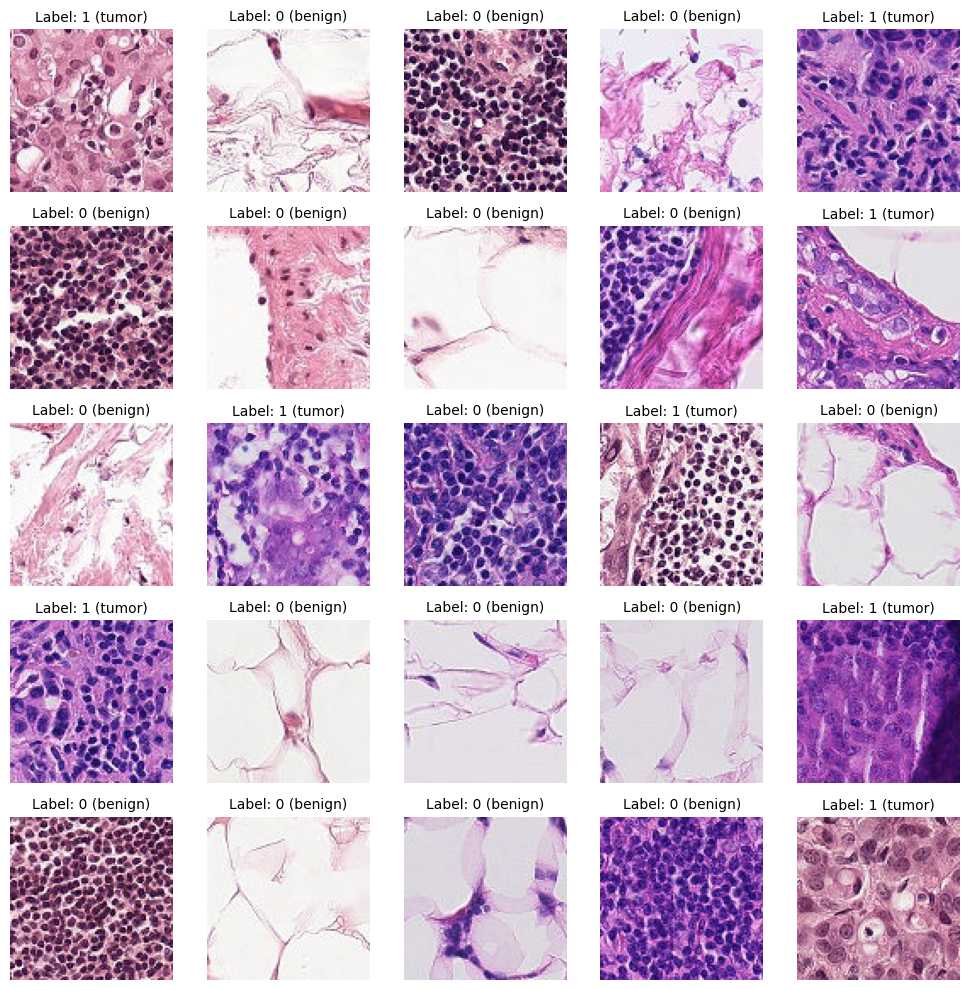

In [65]:
mapping = dict(zip(train_labels["id"], train_labels["label"]))
display_images(train_fp, 5, 5, mapping)

### Class Distribution

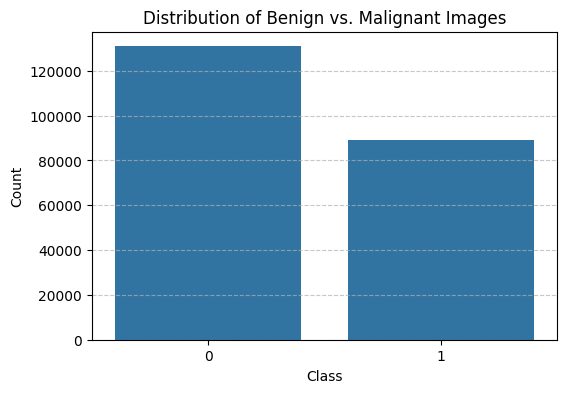

In [39]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_labels, x='label')
plt.title('Distribution of Benign vs. Malignant Images')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The class (label) distribution is skewed towards benign (0) images.

## Data Processing

### Training on data chunks
The full dataset may require a lot of memory and compute time. For the first model, we can train the model in batches. Specifically, we can load in a small chunk of the data (5%), train the model, then save the model checkpoint. Then we can release the memory to allow for the next data sample, load the saved model, and resume training. Once we are confident that our model is learning and can achieve a relatively high accuracy score (~70-80%), we can attempt to utilize the full dataset.

Defined below is a `Dataset` object for loading in the images. We will use the `cv2` module from the `OpenCV` library to load the images. In our `PyTorch` framework, we will need to use the `__len__` and `__getitem__` functions for our `DataLoader`.

**Note about the custom `Dataset` class**:
Using the class as defined in the Jupyter code cell causes an `AttributeError` if multiprocessing is enabled (`num_workers > 0` in the `DataLoader` class). An internet search explains that there is likely a referencing error when defining the custom class inside the notebook. A workaround for this is to define the custom class, i.e. `CustomImageDataset` in a separate `.py` file in the same directory as the notebook, then importing the function as a module (`from image_dataset import CustomImageDataset`).

The markdown cell below shows the custom class in Python code format.

```
class CustomImageDataset(Dataset):
    def __init__(self, df, image_dir):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_id = self.df.iloc[idx]['id']
        label = self.df.iloc[idx]['label']
        fp = os.path.join(self.image_dir, f"{image_id}.tif")
        
        image = cv2.imread(fp)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)        
        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))

        return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
```

In [7]:
BATCH_SIZE = 32
N_EPOCHS = 20
N_CLASSES = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FP = train_fp

N_SAMPLES = 25000
N_CHUNKS = 5
CHECKPOINT_FP = "models/model_checkpoint.pt"

### Simple CNN Model
We will first define a simple CNN with 5 layers (3 `Conv2D` layers and 2 fully connected layers). This architecture is relatively shallow, which may be satisfactory for a binary classification problem. The image dimensions are small, so we do not necessarily need a deep architecture to extract the relevant features. Depending on the performance of this model, we may consider utilizing a deeper model.

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
def train_model(df_full, image_dir, N_CHUNKS, model=SimpleCNN(num_classes=N_CLASSES).to(DEVICE), model_save_path="models/model_checkpoint.pt"):
    df0 = df_full[df_full["label"] == 0].sample(frac=1, random_state=42).reset_index(drop=True)
    df1 = df_full[df_full["label"] == 1].sample(frac=1, random_state=42).reset_index(drop=True)
    
    per_class = N_SAMPLES // 2

    for chunk_idx in range(N_CHUNKS):
        print(f"\n Training on chunk {chunk_idx + 1}/{N_CHUNKS}")

        # Indices for getting new samples for each training chunk
        start = chunk_idx * per_class
        end = start + per_class

        chunk_df = pd.concat([
            df0.iloc[start:end],
            df1.iloc[start:end]]).sample(frac=1).reset_index(drop=True)

        # Split data in train and validation sets
        train_df, val_df = train_test_split(chunk_df, test_size=0.2, stratify=chunk_df["label"], random_state=42)

        # Load dataset
        train_dataset = CustomImageDataset(train_df, image_dir)
        val_dataset = CustomImageDataset(val_df, image_dir)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

        # Load saved model (after first chunk)
        if chunk_idx > 0:
            model.load_state_dict(torch.load(model_save_path))

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        model.train()
        for epoch in range(N_EPOCHS):
            running_loss = 0.0
            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{N_EPOCHS}", leave=False)
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

            avg_loss = running_loss / len(train_loader)
            print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f}")

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = correct / total
        print(f" Validation Accuracy: {acc:.4f}")

        # Save model
        torch.save(model.state_dict(), model_save_path)

        # Release memory
        del train_loader, val_loader, train_dataset, val_dataset
        torch.cuda.empty_cache()

In [10]:
train_model(train_labels, FP, N_CHUNKS)


 Training on chunk 1/5


Epoch 1: Avg Train Loss = 0.5125


Epoch 2: Avg Train Loss = 0.4618


Epoch 3: Avg Train Loss = 0.4535


Epoch 4: Avg Train Loss = 0.4229


Epoch 5: Avg Train Loss = 0.3978


Epoch 6: Avg Train Loss = 0.3558


Epoch 7: Avg Train Loss = 0.3214


Epoch 8: Avg Train Loss = 0.2748


Epoch 9: Avg Train Loss = 0.2231


Epoch 10: Avg Train Loss = 0.1704


Epoch 11: Avg Train Loss = 0.1234


Epoch 12: Avg Train Loss = 0.0851


Epoch 13: Avg Train Loss = 0.0710


Epoch 14: Avg Train Loss = 0.0537


Epoch 15: Avg Train Loss = 0.0410


Epoch 16: Avg Train Loss = 0.0364


Epoch 17: Avg Train Loss = 0.0442


Epoch 18: Avg Train Loss = 0.0284


Epoch 19: Avg Train Loss = 0.0296


Epoch 20: Avg Train Loss = 0.0388
 Validation Accuracy: 0.8152

 Training on chunk 2/5


Epoch 1: Avg Train Loss = 0.4108


Epoch 2: Avg Train Loss = 0.3186


Epoch 3: Avg Train Loss = 0.2727


Epoch 4: Avg Train Loss = 0.2125


Epoch 5: Avg Train Loss = 0.1522


Epoch 6: Avg Train Loss = 0.1023


Epoch 7: Avg Train Loss = 0.0594


Epoch 8: Avg Train Loss = 0.0425


Epoch 9: Avg Train Loss = 0.0420


Epoch 10: Avg Train Loss = 0.0287


Epoch 11: Avg Train Loss = 0.0280


Epoch 12: Avg Train Loss = 0.0233


Epoch 13: Avg Train Loss = 0.0275


Epoch 14: Avg Train Loss = 0.0224


Epoch 15: Avg Train Loss = 0.0186


Epoch 16: Avg Train Loss = 0.0135


Epoch 17: Avg Train Loss = 0.0183


Epoch 18: Avg Train Loss = 0.0244


Epoch 19: Avg Train Loss = 0.0168


Epoch 20: Avg Train Loss = 0.0206
 Validation Accuracy: 0.8218

 Training on chunk 3/5


Epoch 1: Avg Train Loss = 0.4095


Epoch 2: Avg Train Loss = 0.3191


Epoch 3: Avg Train Loss = 0.2647


Epoch 4: Avg Train Loss = 0.2138


Epoch 5: Avg Train Loss = 0.1479


Epoch 6: Avg Train Loss = 0.0844


Epoch 7: Avg Train Loss = 0.0422


Epoch 8: Avg Train Loss = 0.0321


Epoch 9: Avg Train Loss = 0.0252


Epoch 10: Avg Train Loss = 0.0248


Epoch 11: Avg Train Loss = 0.0168


Epoch 12: Avg Train Loss = 0.0258


Epoch 13: Avg Train Loss = 0.0148


Epoch 14: Avg Train Loss = 0.0299


Epoch 15: Avg Train Loss = 0.0153


Epoch 16: Avg Train Loss = 0.0162


Epoch 17: Avg Train Loss = 0.0134


Epoch 18: Avg Train Loss = 0.0164


Epoch 19: Avg Train Loss = 0.0213


Epoch 20: Avg Train Loss = 0.0094
 Validation Accuracy: 0.8246

 Training on chunk 4/5


Epoch 1: Avg Train Loss = 0.3963


Epoch 2: Avg Train Loss = 0.2944


Epoch 3: Avg Train Loss = 0.2286


Epoch 4: Avg Train Loss = 0.1600


Epoch 5: Avg Train Loss = 0.0935


Epoch 6: Avg Train Loss = 0.0500


Epoch 7: Avg Train Loss = 0.0302


Epoch 8: Avg Train Loss = 0.0367


Epoch 9: Avg Train Loss = 0.0232


Epoch 10: Avg Train Loss = 0.0197


Epoch 11: Avg Train Loss = 0.0219


Epoch 12: Avg Train Loss = 0.0168


Epoch 13: Avg Train Loss = 0.0183


Epoch 14: Avg Train Loss = 0.0247


Epoch 15: Avg Train Loss = 0.0116


Epoch 16: Avg Train Loss = 0.0030


Epoch 17: Avg Train Loss = 0.0040


Epoch 18: Avg Train Loss = 0.0409


Epoch 19: Avg Train Loss = 0.0166


Epoch 20: Avg Train Loss = 0.0106
 Validation Accuracy: 0.8444

 Training on chunk 5/5


Epoch 1: Avg Train Loss = 0.3959


Epoch 2: Avg Train Loss = 0.2880


Epoch 3: Avg Train Loss = 0.2112


Epoch 4: Avg Train Loss = 0.1453


Epoch 5: Avg Train Loss = 0.0830


Epoch 6: Avg Train Loss = 0.0405


Epoch 7: Avg Train Loss = 0.0306


Epoch 8: Avg Train Loss = 0.0231


Epoch 9: Avg Train Loss = 0.0295


Epoch 10: Avg Train Loss = 0.0158


Epoch 11: Avg Train Loss = 0.0231


Epoch 12: Avg Train Loss = 0.0162


Epoch 13: Avg Train Loss = 0.0164


Epoch 14: Avg Train Loss = 0.0201


Epoch 15: Avg Train Loss = 0.0123


Epoch 16: Avg Train Loss = 0.0222


Epoch 17: Avg Train Loss = 0.0148


Epoch 18: Avg Train Loss = 0.0109


Epoch 19: Avg Train Loss = 0.0079


Epoch 20: Avg Train Loss = 0.0185
 Validation Accuracy: 0.8470


After completing training, we can load the model for inference on the new data.

In [9]:
inference_model = SimpleCNN(num_classes=2)
inference_model.load_state_dict(torch.load("models/model_checkpoint.pt"))
inference_model.to(DEVICE)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [10]:
def inference_preprocess(fp):
    image = cv2.imread(fp)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    return torch.tensor(image, dtype=torch.float32).unsqueeze(0)

def infer_img(image_tensor, inference_model, device):
    image_tensor = image_tensor.to(device)
    inference_model.eval()
    with torch.no_grad():
        output = inference_model(image_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        prob = torch.softmax(output, dim=1)
        confidence = prob[0][pred_class].item()
    return pred_class, confidence

def infer(fp, model, device):
    results = []

    for fn in os.listdir(fp):
        image_fp = os.path.join(fp, fn)
        image_tensor = inference_preprocess(image_fp)
        pred_class, _ = infer_img(image_tensor, model, device)
        results.append({"id": fn[:-4],
                        "label": pred_class})
        
    return pd.DataFrame(results)

In [16]:
results = infer(test_fp, inference_model, DEVICE)

In [17]:
results.to_csv("submission.csv", index=False)

### Kaggle Submission Results (SimpleCNN)
* `N_CHUNKS` = 5
* `N_EPOCHS` = 10
* `SAMPLE_SIZE` = 10000
  
![Kaggle Submission](scores/simple_cnn_score1.png)

_______________________________________________________________________________________________________________________________________________________
* `N_CHUNKS` = 10
* `N_EPOCHS` = 10
* `SAMPLE_SIZE` = 12500

![Kaggle Submission](scores/simple_cnn_score2.png)
_______________________________________________________________________________________________________________________________________________________
* `N_CHUNKS` = 5
* `N_EPOCHS` = 20
* `SAMPLE_SIZE` = 25000

![Kaggle Submission](scores/simple_cnn_score3.png)
_______________________________________________________________________________________________________________________________________________________

The best `SimpleCNN` model achieves an accuracy score of `0.8344` on the public test data-set, after training in chunks on ~50% of the training data. 

### Improving the model
We will make the following additions to our model:
* Add another `Conv2D` layer
* Add batch normalization
* Add dropout layer
* Adjust Learning rate
* Adjust batch size / number of epochs

In [11]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(DeepCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=0)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.bn4 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(64*4*4, 512)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [16]:
BATCH_SIZE = 16
N_EPOCHS = 50
N_CLASSES = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
FP = train_fp
MODEL_SAVE_FP = "models/full_data_model_16.pt"
EARLY_STOP = 10
torch.cuda.empty_cache()

In [17]:
train_df, val_df = train_test_split(
    train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42
)

train_dataset = CustomImageDataset(train_df, FP)
val_dataset = CustomImageDataset(val_df, FP)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

model = DeepCNN(num_classes=2).to(DEVICE)

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

best_val_acc = 0
epochs_no_improve = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{N_EPOCHS}]", leave=False)

    for images, labels in pbar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{N_EPOCHS} -> Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_SAVE_FP)
        print(f"Saved new best model at epoch {epoch+1}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= EARLY_STOP:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1/50 -> Train Loss: 0.3693 - Validation Loss: 0.2866 - Validation Accuracy: 0.8814
Saved new best model at epoch 1


Epoch 2/50 -> Train Loss: 0.3005 - Validation Loss: 0.2707 - Validation Accuracy: 0.8882
Saved new best model at epoch 2


Epoch 3/50 -> Train Loss: 0.2717 - Validation Loss: 0.2477 - Validation Accuracy: 0.8981
Saved new best model at epoch 3


Epoch 4/50 -> Train Loss: 0.2526 - Validation Loss: 0.2476 - Validation Accuracy: 0.9001
Saved new best model at epoch 4


Epoch 5/50 -> Train Loss: 0.2377 - Validation Loss: 0.3359 - Validation Accuracy: 0.8783
No improvement for 1 epoch(s).


Epoch 6/50 -> Train Loss: 0.2256 - Validation Loss: 0.2317 - Validation Accuracy: 0.9085
Saved new best model at epoch 6


Epoch 7/50 -> Train Loss: 0.2174 - Validation Loss: 0.1942 - Validation Accuracy: 0.9236
Saved new best model at epoch 7


Epoch 8/50 -> Train Loss: 0.2098 - Validation Loss: 0.2130 - Validation Accuracy: 0.9160
No improvement for 1 epoch(s).


Epoch 9/50 -> Train Loss: 0.2028 - Validation Loss: 0.2059 - Validation Accuracy: 0.9191
No improvement for 2 epoch(s).


Epoch 10/50 -> Train Loss: 0.1980 - Validation Loss: 0.2389 - Validation Accuracy: 0.9054
No improvement for 3 epoch(s).


Epoch 11/50 -> Train Loss: 0.1930 - Validation Loss: 0.2150 - Validation Accuracy: 0.9160
No improvement for 4 epoch(s).


Epoch 12/50 -> Train Loss: 0.1877 - Validation Loss: 0.5281 - Validation Accuracy: 0.8203
No improvement for 5 epoch(s).


Epoch 13/50 -> Train Loss: 0.1845 - Validation Loss: 0.1826 - Validation Accuracy: 0.9303
Saved new best model at epoch 13


Epoch 14/50 -> Train Loss: 0.1815 - Validation Loss: 0.2035 - Validation Accuracy: 0.9228
No improvement for 1 epoch(s).


Epoch 15/50 -> Train Loss: 0.1771 - Validation Loss: 0.2012 - Validation Accuracy: 0.9214
No improvement for 2 epoch(s).


Epoch 16/50 -> Train Loss: 0.1745 - Validation Loss: 0.1905 - Validation Accuracy: 0.9263
No improvement for 3 epoch(s).


Epoch 17/50 -> Train Loss: 0.1717 - Validation Loss: 0.2084 - Validation Accuracy: 0.9202
No improvement for 4 epoch(s).


Epoch 18/50 -> Train Loss: 0.1680 - Validation Loss: 0.1842 - Validation Accuracy: 0.9303
No improvement for 5 epoch(s).


Epoch 19/50 -> Train Loss: 0.1657 - Validation Loss: 0.2249 - Validation Accuracy: 0.9140
No improvement for 6 epoch(s).


Epoch 20/50 -> Train Loss: 0.1656 - Validation Loss: 0.1942 - Validation Accuracy: 0.9263
No improvement for 7 epoch(s).


Epoch 21/50 -> Train Loss: 0.1620 - Validation Loss: 0.1930 - Validation Accuracy: 0.9270
No improvement for 8 epoch(s).


Epoch 22/50 -> Train Loss: 0.1610 - Validation Loss: 0.1919 - Validation Accuracy: 0.9283
No improvement for 9 epoch(s).


Epoch 23/50 -> Train Loss: 0.1587 - Validation Loss: 0.1999 - Validation Accuracy: 0.9304
Saved new best model at epoch 23


Epoch 24/50 -> Train Loss: 0.1567 - Validation Loss: 0.1833 - Validation Accuracy: 0.9295
No improvement for 1 epoch(s).


Epoch 25/50 -> Train Loss: 0.1541 - Validation Loss: 0.1950 - Validation Accuracy: 0.9266
No improvement for 2 epoch(s).


Epoch 26/50 -> Train Loss: 0.1528 - Validation Loss: 0.2041 - Validation Accuracy: 0.9222
No improvement for 3 epoch(s).


Epoch 27/50 -> Train Loss: 0.1511 - Validation Loss: 0.2002 - Validation Accuracy: 0.9253
No improvement for 4 epoch(s).


Epoch 28/50 -> Train Loss: 0.1496 - Validation Loss: 0.1918 - Validation Accuracy: 0.9298
No improvement for 5 epoch(s).


Epoch 29/50 -> Train Loss: 0.1480 - Validation Loss: 0.1887 - Validation Accuracy: 0.9289
No improvement for 6 epoch(s).


Epoch 30/50 -> Train Loss: 0.1454 - Validation Loss: 0.1995 - Validation Accuracy: 0.9285
No improvement for 7 epoch(s).


Epoch 31/50 -> Train Loss: 0.1456 - Validation Loss: 0.1870 - Validation Accuracy: 0.9304
Saved new best model at epoch 31


Epoch 32/50 -> Train Loss: 0.1448 - Validation Loss: 0.2012 - Validation Accuracy: 0.9233
No improvement for 1 epoch(s).


Epoch 33/50 -> Train Loss: 0.1428 - Validation Loss: 0.1932 - Validation Accuracy: 0.9297
No improvement for 2 epoch(s).


Epoch 34/50 -> Train Loss: 0.1421 - Validation Loss: 0.2105 - Validation Accuracy: 0.9236
No improvement for 3 epoch(s).


Epoch 35/50 -> Train Loss: 0.1390 - Validation Loss: 0.1918 - Validation Accuracy: 0.9291
No improvement for 4 epoch(s).


Epoch 36/50 -> Train Loss: 0.1393 - Validation Loss: 0.2133 - Validation Accuracy: 0.9260
No improvement for 5 epoch(s).


Epoch 37/50 -> Train Loss: 0.1384 - Validation Loss: 0.1931 - Validation Accuracy: 0.9289
No improvement for 6 epoch(s).


Epoch 38/50 -> Train Loss: 0.1387 - Validation Loss: 0.1959 - Validation Accuracy: 0.9281
No improvement for 7 epoch(s).


Epoch 39/50 -> Train Loss: 0.1361 - Validation Loss: 0.2006 - Validation Accuracy: 0.9251
No improvement for 8 epoch(s).


Epoch 40/50 -> Train Loss: 0.1355 - Validation Loss: 0.1994 - Validation Accuracy: 0.9293
No improvement for 9 epoch(s).


Epoch 41/50 -> Train Loss: 0.1333 - Validation Loss: 0.2132 - Validation Accuracy: 0.9278
No improvement for 10 epoch(s).
Early stopping triggered at epoch 41


### Kaggle Submission Results (DeepCNN)
* `N_CHUNKS` = 1
* `N_EPOCHS` = 50
* `SAMPLE_SIZE` = 220025
* `BATCH_SIZE` = 32
* `lr` = 1e-3
  
![Kaggle Submission](scores/deep_cnn_score1.png)

_______________________________________________________________________________________________________________________________________________________
* `N_CHUNKS` = 1
* `N_EPOCHS` = 50
* `SAMPLE_SIZE` = 220025
* `BATCH_SIZE` = 16
* `lr` = 1e-4
 
![Kaggle Submission](scores/deep_cnn_score2.png)
_______________________________________________________________________________________________________________________________________________________
* `N_CHUNKS` = 1
* `N_EPOCHS` = 50
* `SAMPLE_SIZE` = 220025
* `BATCH_SIZE` = 16
* `lr` = 1e-3

![Kaggle Submission](scores/deep_cnn_score3.png)
_______________________________________________________________________________________________________________________________________________________

The best performing `DeepCNN` model on the test data was the model with `BATCH_SIZE` = 32 and `lr` = 1e-3 trained on the full dataset, with a score of `0.8589`.

In [18]:
# Save training metrics
# metrics_df = pd.DataFrame({
#     "Epoch": list(range(1, len(train_losses)+1)),
#     "Train Loss": train_losses,
#     "Val Loss": val_losses,
#     "Val Accuracy": val_accuracies
# })

# metrics_df.to_csv("training_metrics3.csv", index=False)

In [41]:
deep_inference_model = DeepCNN(num_classes=2)
deep_inference_model.load_state_dict(torch.load(MODEL_SAVE_FP))
deep_inference_model.to(DEVICE)

DeepCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [42]:
def get_params(model):
    total = sum([i.numel() for i in model.parameters()])
    trainable = sum([i.numel() for i in model.parameters() if i.requires_grad])
    print(f"Total parameters: {total}")
    print(f"Trainable parameters: {trainable}")
    print(f"Untrainable parameters: {total-trainable}")

In [43]:
get_params(deep_inference_model)

Total parameters: 550594
Trainable parameters: 550594
Untrainable parameters: 0


In [23]:
deep_model_results = infer(test_fp, deep_inference_model, DEVICE)

In [24]:
deep_model_results.to_csv("deep_model_submission_batch16.csv", index=False)

## Summary of Results

### `SimpleCNN`

|`N_CHUNKS`|`N_EPOCHS`|`SAMPLE_SIZE`|`BATCH_SIZE`|  `lr`  |`acc_score`|
| ---------|----------|-------------|------------|--------|-----------|
|    5     |    10    |    10000    |     32     |  1e-3  |  0.8033   |
|    10    |    10    |    12500    |     32     |  1e-3  |  0.8344   |
|    5     |    20    |    25000    |     32     |  1e-3  |  0.8272   |

### `DeepCNN`

|`N_CHUNKS`|`N_EPOCHS`|`SAMPLE_SIZE`|`BATCH_SIZE`|  `lr`  |`acc_score`|
| ---------|----------|-------------|------------|--------|-----------|
|    1     |    50    |   220025    |     32     |  1e-3  |  0.8589   |
|    1     |    50    |   220025    |     16     |  1e-4  |  0.8215   |
|    1     |    50    |   220025    |     16     |  1e-3  |  0.8572   |

The `DeepCNN` performs slightly better than the `SimpleCNN` on the test dataset. The combination of parameters that performed the best was `BATCH_SIZE`= 32, `N_EPOCHS`= 50, and `lr` = 1e-3 on the full dataset. Training on the full dataset at once seems to perform marginally better than on a sub-set in chunks. This suggests that both the `SimpleCNN` and `DeepCNN` models generalize similarly and will likely require a deeper network to increase the performance past 85% accuracy.

### Training metrics for `DeepCNN`

In [55]:
# M1: batch=32, lr=1e-3
metrics1 = pd.read_csv("training_metrics1.csv")
# M2: batch=16, lr=1e-4
metrics2 = pd.read_csv("training_metrics2.csv")
# M3: batch=16, lr=1e-3
metrics3 = pd.read_csv("training_metrics3.csv")

### Train loss

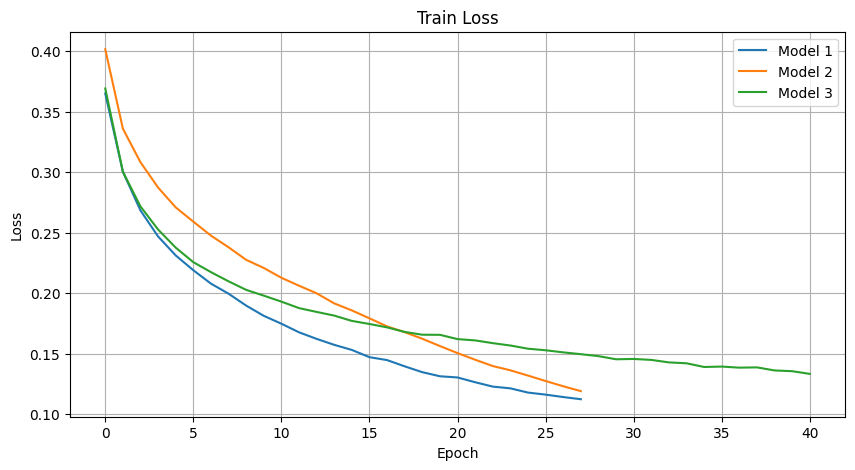

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(metrics1['Train Loss'], label="Model 1")
plt.plot(metrics2['Train Loss'], label="Model 2")
plt.plot(metrics3['Train Loss'], label="Model 3")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss")
plt.legend()
plt.grid(True)
plt.show()

### Validation loss

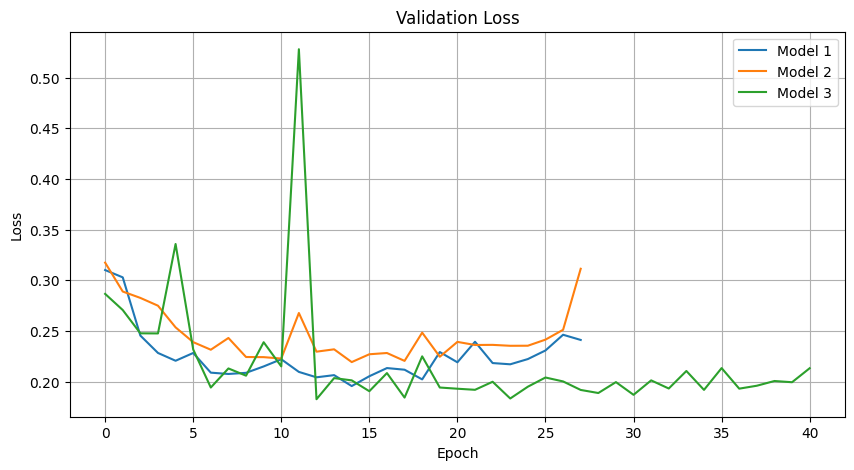

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(metrics1['Val Loss'], label="Model 1")
plt.plot(metrics2['Val Loss'], label="Model 2")
plt.plot(metrics3['Val Loss'], label="Model 3")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Validation accuracy

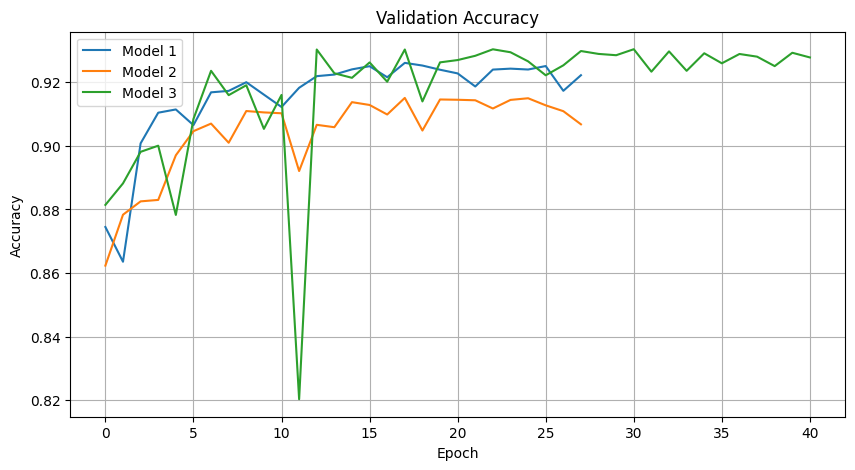

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(metrics1['Val Accuracy'], label="Model 1")
plt.plot(metrics2['Val Accuracy'], label="Model 2")
plt.plot(metrics3['Val Accuracy'], label="Model 3")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

The validation accuracy seems to plateau at roughly 92% across all 3 `DeepCNN` models. The score on inference, however, peaks at 85% between the models. This suggests that there might be some overfitting, even when trained on the full dataset. To push the inference score closer to the validation scores may require additional parameter tuning, modifications to the network architecture, and/or data augmentation. However, the possible tradeoff is longer compute time, as training on the full dataset require more train time than using a subset, and data augmentation would add more samples.

To address compute and memory requirements, we could consider leveraging cloud GPU resources, specifically training directly on Kaggle's compute resources, provided that the train time does not exceed the weekly alloted amount (~30 hours). We may also consider transfer learning and leverage pretrained models such as `ResNet` or `ImageNet`.

## References

* https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
* https://pytorch.org/
* https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/
* https://ieeexplore.ieee.org/document/5206848